In [4]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 6s 0us/step


In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [6]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
#Directories for the training, validation, and test splits
train_dir = 'C:\\Users\\HP\\Downloads\\cats_and_dogs_small\\train'
validation_dir = 'C:\\Users\\HP\\Downloads\\cats_and_dogs_small\\validation'
test_dir = 'C:\\Users\\HP\\Downloads\\cats_and_dogs_small\\test'
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

In [18]:
def extract_features(directory, sample_count):
    # directory = the image file path
    # sample_count = how many sample in train or val or test
    
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features, labels

In [19]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
train_features.shape

(2000, 4, 4, 512)

In [21]:
#flatten
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [23]:
# Define the densely connected classifier
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])


history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
63/63 [==============================] - 3s 37ms/step - loss: 0.6499 - acc: 0.6275 - val_loss: 0.4841 - val_acc: 0.8210
Epoch 2/30
63/63 [==============================] - 2s 34ms/step - loss: 0.4866 - acc: 0.7700 - val_loss: 0.3967 - val_acc: 0.8460
Epoch 3/30
63/63 [==============================] - 2s 34ms/step - loss: 0.3842 - acc: 0.8390 - val_loss: 0.3490 - val_acc: 0.8690
Epoch 4/30
63/63 [==============================] - 2s 34ms/step - loss: 0.3490 - acc: 0.8525 - val_loss: 0.3224 - val_acc: 0.8790
Epoch 5/30
63/63 [==============================] - 2s 35ms/step - loss: 0.3162 - acc: 0.8760 - val_loss: 0.3030 - val_acc: 0.8820
Epoch 6/30
63/63 [==============================] - 3s 42ms/step - loss: 0.2961 - acc: 0.8850 - val_loss: 0.2883 - val_acc: 0.8900
Epoch 7/30
63/63 [==============================] - 3s 40ms/step - loss: 0.2726 - acc: 0.8905 - val_loss: 0.2794 - val_acc: 0.8870
Epoch 8/30
63/63 [==============================] - 3s 42ms/step - loss: 0.2611 - a

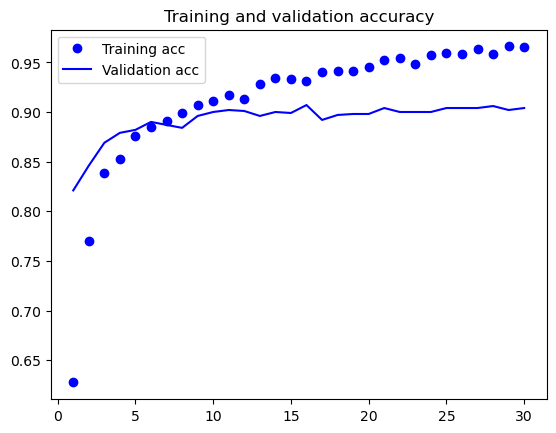

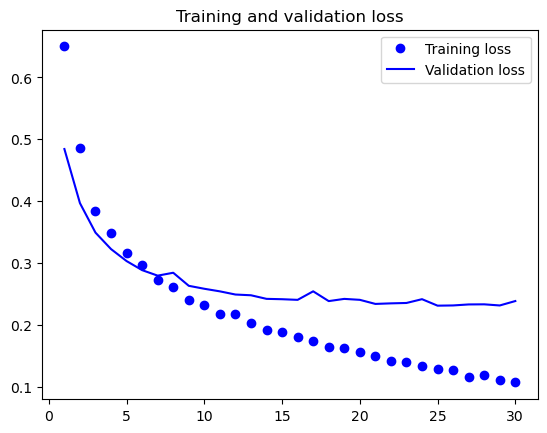

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Feature Extraction with Augmentation

In [26]:
#Adding a densely connected classifier on top of the convolutional base
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [28]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [29]:
conv_base.trainable = False
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')


validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')


model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=30,
validation_data=validation_generator,validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 236s 2s/step - loss: 0.5029 - acc: 0.7715 - val_loss: 0.3855 - val_acc: 0.8430
Epoch 2/30
100/100 [==============================] - 242s 2s/step - loss: 0.4350 - acc: 0.8085 - val_loss: 0.3434 - val_acc: 0.8480
Epoch 3/30
100/100 [==============================] - 231s 2s/step - loss: 0.4101 - acc: 0.8100 - val_loss: 0.3129 - val_acc: 0.8720
Epoch 4/30
100/100 [==============================] - 231s 2s/step - loss: 0.3742 - acc: 0.8395 - val_loss: 0.3076 - val_acc: 0.8670
Epoch 5/30
100/100 [==============================] - 232s 2s/step - loss: 0.3810 - acc: 0.8275 - val_loss: 0.2869 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 231s 2s/step - loss: 0.3616 - acc: 0.8450 - val_loss: 0.2792 - val_acc: 0.8870
Epoch 7/30
100/100 [==============================] - 229s 2s/step - loss: 0.3458 - acc: 0.8595 - val_loss: 0.2678 - v

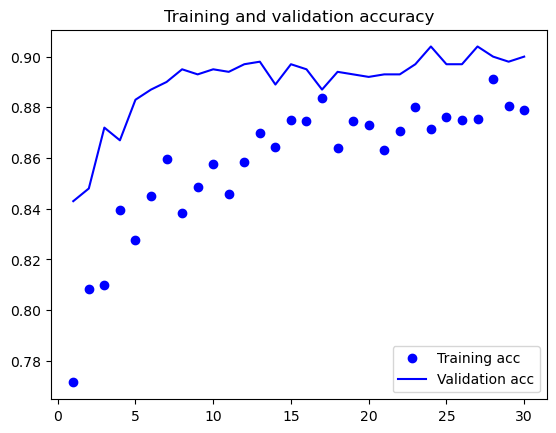

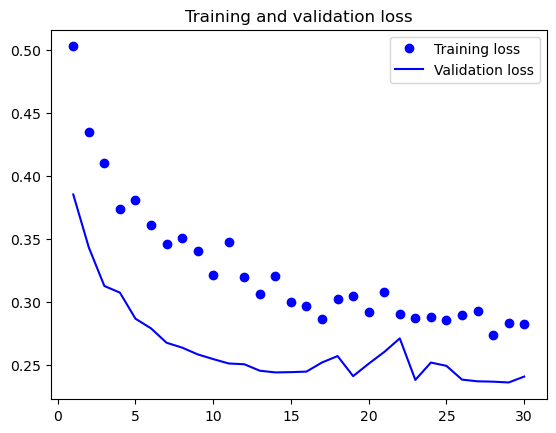

In [32]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [33]:
# Fine-Tuning
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [34]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 261s 3s/step - loss: 0.2836 - acc: 0.8815 - val_loss: 0.2290 - val_acc: 0.9010
Epoch 2/100
100/100 [==============================] - 265s 3s/step - loss: 0.2636 - acc: 0.8850 - val_loss: 0.2127 - val_acc: 0.9190
Epoch 3/100
100/100 [==============================] - 267s 3s/step - loss: 0.2447 - acc: 0.9075 - val_loss: 0.2058 - val_acc: 0.9190
Epoch 4/100
100/100 [==============================] - 267s 3s/step - loss: 0.2226 - acc: 0.9030 - val_loss: 0.1967 - val_acc: 0.9230
Epoch 5/100
100/100 [==============================] - 266s 3s/step - loss: 0.2117 - acc: 0.9110 - val_loss: 0.1962 - val_acc: 0.9240
Epoch 6/100
100/100 [==============================] - 269s 3s/step - loss: 0.1919 - acc: 0.9150 - val_loss: 0.2983 - val_acc: 0.8900
Epoch 7/100
100/100 [==============================] - 268s 3s/step - loss: 0.1783 - acc: 0.9300 - val_loss: 0.2392 - val_acc: 0.9110
Epoch 8/100
100/100 [==============================] - 270s 3s

Epoch 62/100
100/100 [==============================] - 269s 3s/step - loss: 0.0294 - acc: 0.9895 - val_loss: 0.2082 - val_acc: 0.9310
Epoch 63/100
100/100 [==============================] - 266s 3s/step - loss: 0.0364 - acc: 0.9895 - val_loss: 0.2594 - val_acc: 0.9330
Epoch 64/100
100/100 [==============================] - 266s 3s/step - loss: 0.0286 - acc: 0.9885 - val_loss: 0.2294 - val_acc: 0.9320
Epoch 65/100
100/100 [==============================] - 268s 3s/step - loss: 0.0298 - acc: 0.9900 - val_loss: 0.3695 - val_acc: 0.9150
Epoch 66/100
100/100 [==============================] - 265s 3s/step - loss: 0.0294 - acc: 0.9890 - val_loss: 0.2244 - val_acc: 0.9400
Epoch 67/100
100/100 [==============================] - 263s 3s/step - loss: 0.0235 - acc: 0.9915 - val_loss: 0.2270 - val_acc: 0.9410
Epoch 68/100
100/100 [==============================] - 269s 3s/step - loss: 0.0302 - acc: 0.9895 - val_loss: 0.2539 - val_acc: 0.9320
Epoch 69/100
100/100 [==============================] -